In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split
import seaborn as sns

from qiskit.algorithms.optimizers import ADAM, SPSA
from qiskit.circuit.library import TwoLocal, ZZFeatureMap, ZFeatureMap
from qiskit.primitives import BackendEstimator, BackendSampler
from qiskit.quantum_info import Pauli
from qiskit_aer import AerSimulator
from qiskit_algorithms.gradients import ParamShiftEstimatorGradient, ParamShiftSamplerGradient

from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import EstimatorQNN, SamplerQNN
from qiskit_machine_learning.utils.loss_functions import CrossEntropyLoss

/var/folders/pj/xl9d34bx4pj0pw3_0zksj9x00000gn/T/ipykernel_82878/4091864451.py:7: DeprecationWarning: ``qiskit.algorithms`` has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. The ``qiskit.algorithms`` import path is deprecated as of qiskit-terra 0.25.0 and will be removed no earlier than 3 months after the release date. Please run ``pip install qiskit_algorithms`` and use ``import qiskit_algorithms`` instead.
  from qiskit.algorithms.optimizers import ADAM, SPSA


In [2]:
SEED = 89
qasm_sim = AerSimulator()
sns.set_context('poster')
plt.style.use('seaborn-v0_8-colorblind')

In [5]:
# Load data into feature and target variables.
X, y = datasets.load_diabetes(return_X_y=True)

# Print number of features and samples.
print("The Number of Features is: {}".format(X.shape[1]))
print("The Number of Samples is: {}".format(X.shape[0]))

The Number of Features is: 10
The Number of Samples is: 442


In [6]:
# Reserve 25% of data for testing.
test_ratio = 0.25

# Split data into train and test *before* preprocessing to ensure no data leakage.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio, random_state=SEED)

# Print number of samples in each set.
print("There are {} samples in the training set".format(X_train.shape[0]))
print("There are {} samples in the test set".format(X_test.shape[0]))

There are 331 samples in the training set
There are 111 samples in the test set


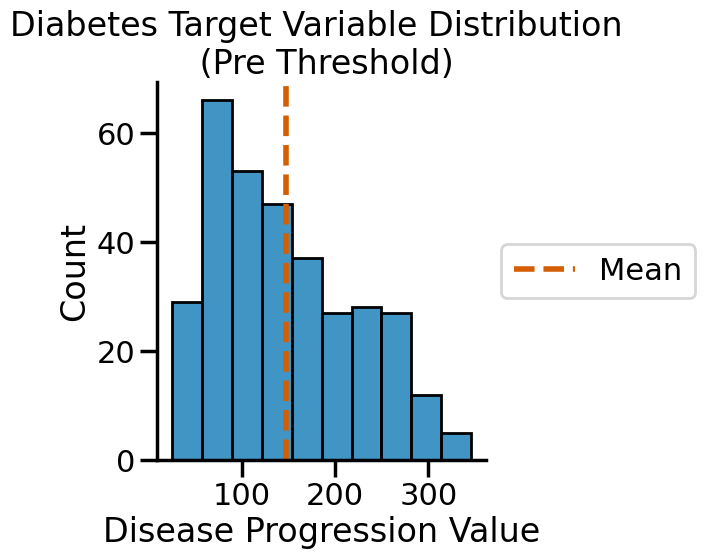

In [7]:
# Target variable statistics.

sns.displot(y_train)
plt.xlabel("Disease Progression Value")
plt.title("Diabetes Target Variable Distribution \n (Pre Threshold)")

plt.axvline(x=y_train.mean(), color=sns.palettes.color_palette('colorblind')[3], ls='--', lw=4, label="Mean")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [8]:
# Get mean disease progression value for thresholding.
y_train_mean = y_train.mean()
print("The mean disease progression value is: {}".format(y_train_mean))

# Threshold the training and test sets based on the mean value.
y_train = np.where(y_train >= y_train_mean, 1, 0)
y_test = np.where(y_test < y_train_mean, 1, 0)

The mean disease progression value is: 147.7250755287009


In [29]:
y_test

array([0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1,
       1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1,
       1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1,
       0])

Text(0.5, 1.0, 'Diabetes Target Variable Distribution \n (Post Threshold)')

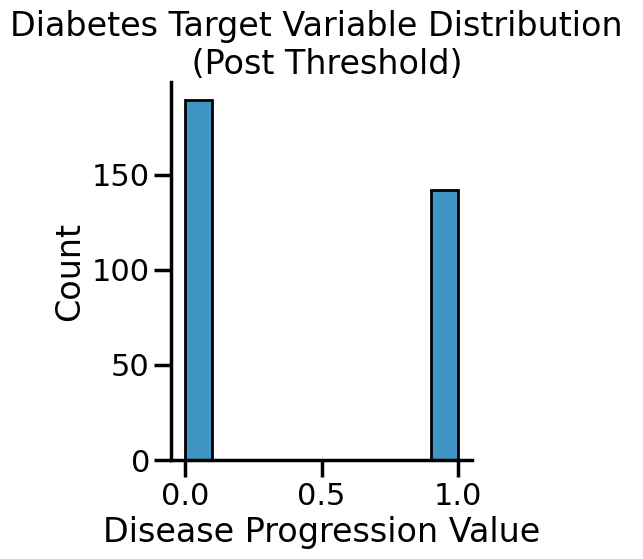

In [9]:
# Target variable statistics.

sns.displot(y_train)
plt.xlabel("Disease Progression Value")
plt.title("Diabetes Target Variable Distribution \n (Post Threshold)")

/Users/hamzahanif/opt/miniconda3/envs/winterschool/lib/python3.9/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


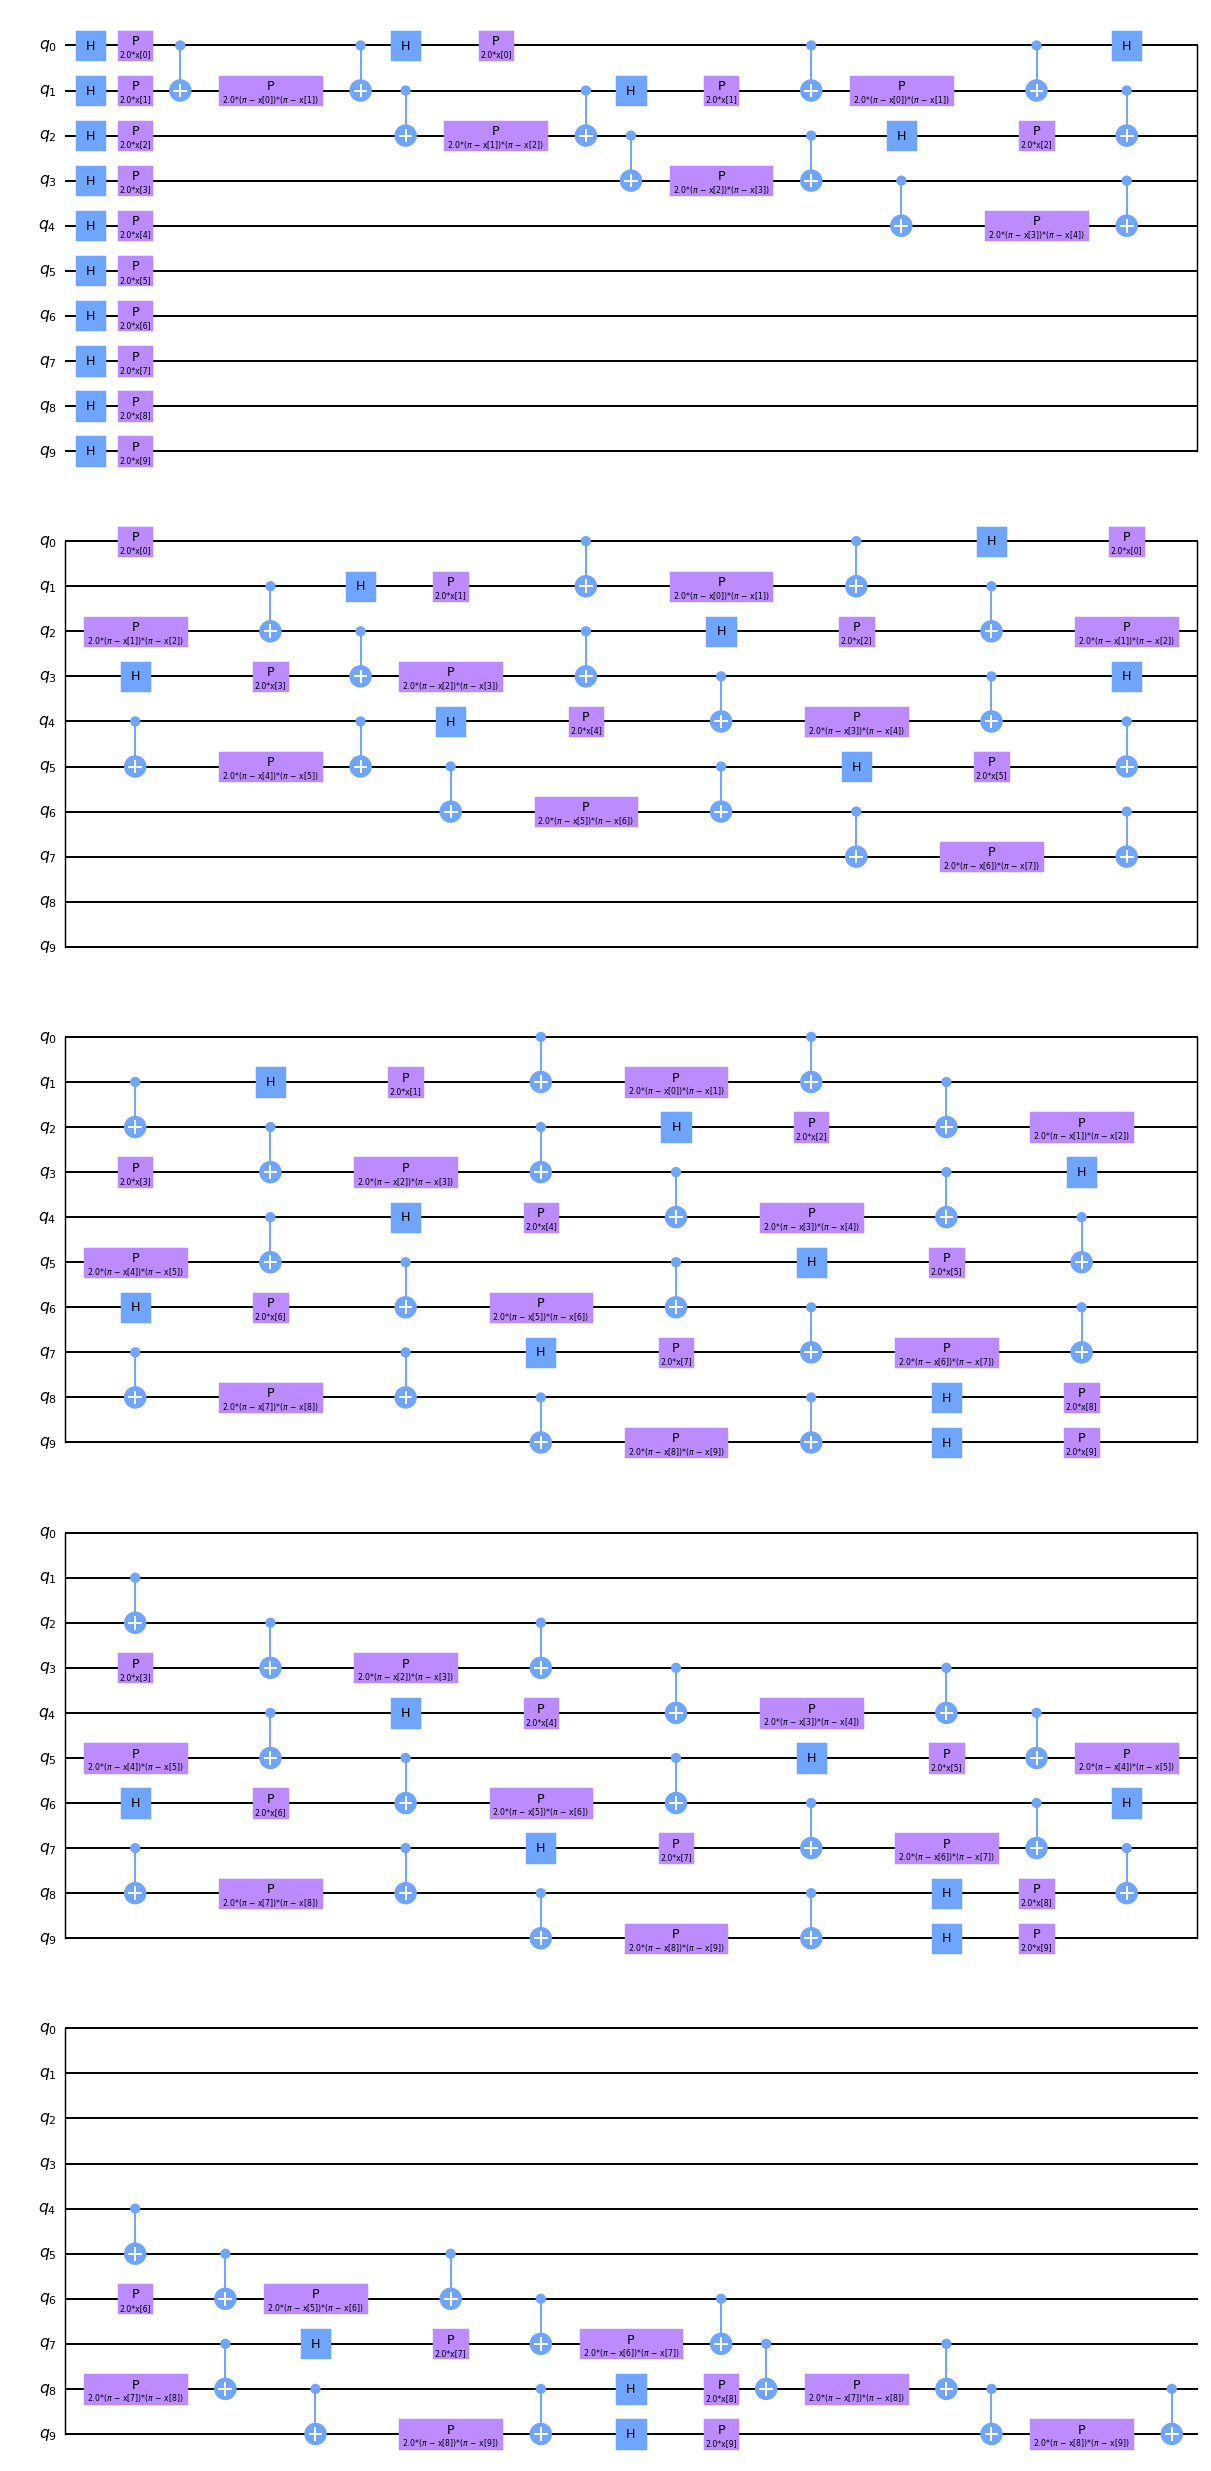

In [84]:
def get_zz_feature_map(feature_dim, feature_map_rep, ent):
    return ZZFeatureMap(feature_dimension=feature_dim, reps=feature_map_rep, entanglement=ent)

num_features = X.shape[1]

fmap_zz = get_zz_feature_map(num_features, 4, 'linear')
input_params = fmap_zz.parameters
fmap_zz.decompose().draw('mpl', scale=0.7)

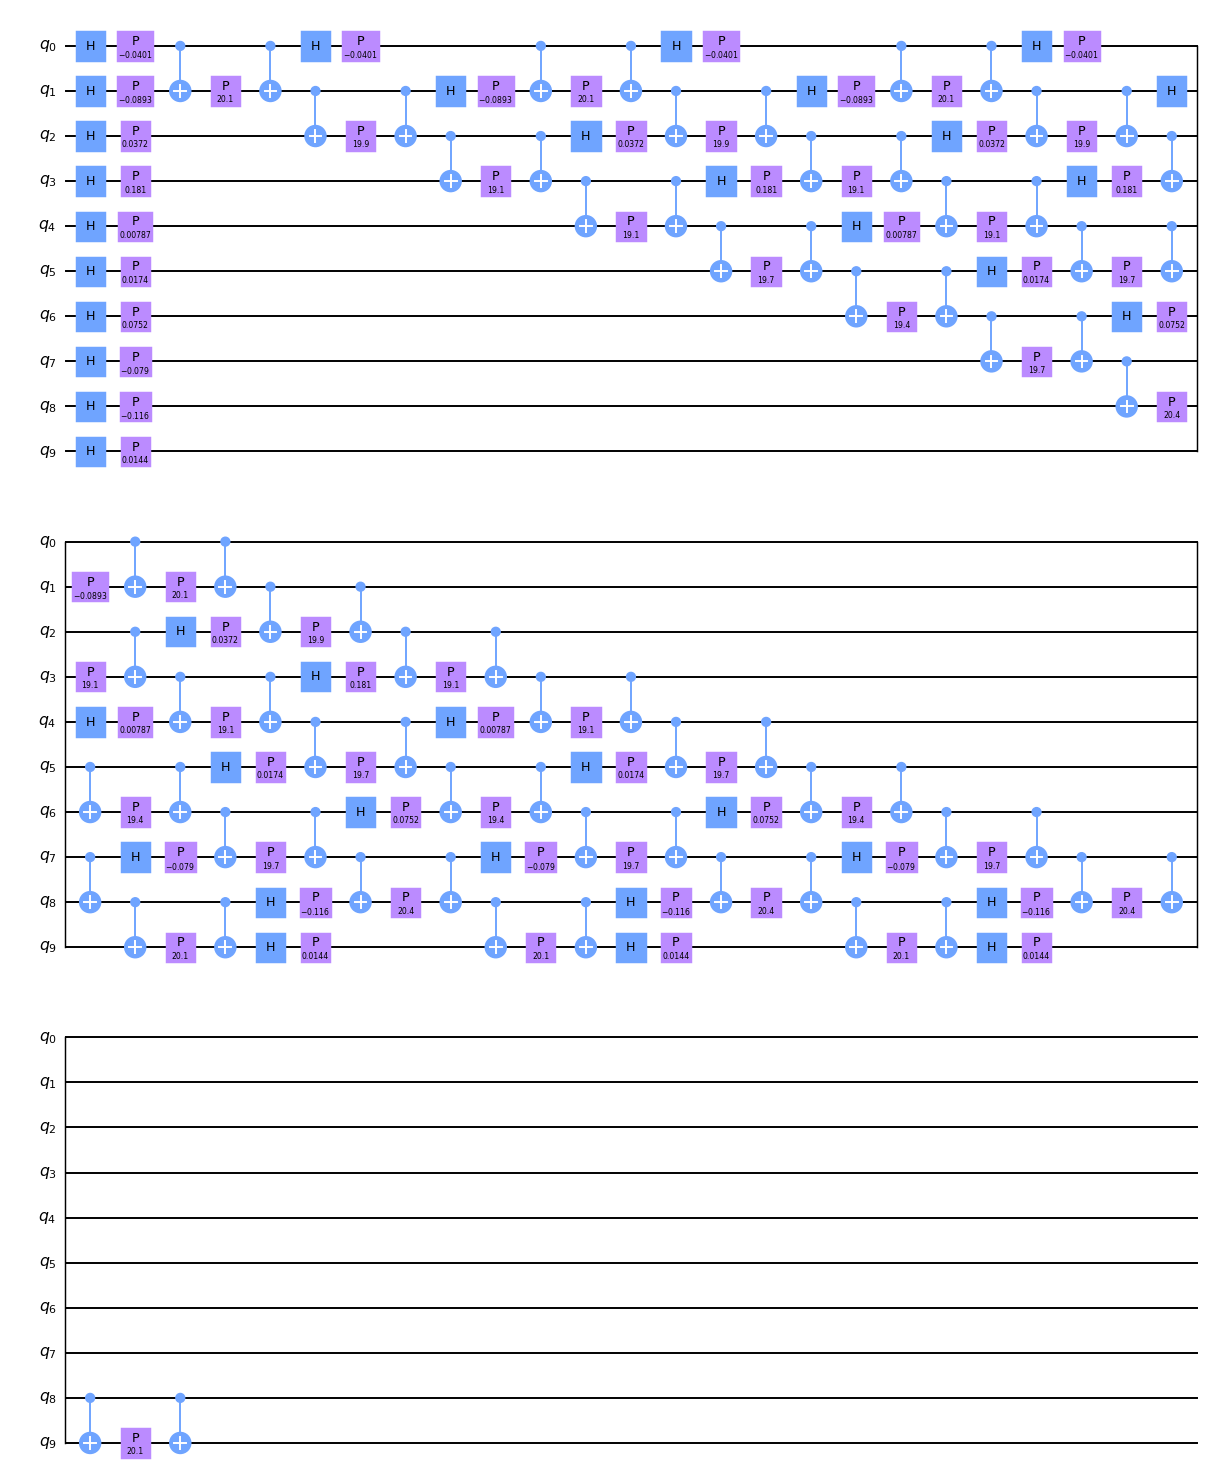

In [85]:
fmap_zz.assign_parameters({k:v for (k,v) in zip(fmap_zz.parameters, X_train[0])}).decompose().draw('mpl', scale=0.7)

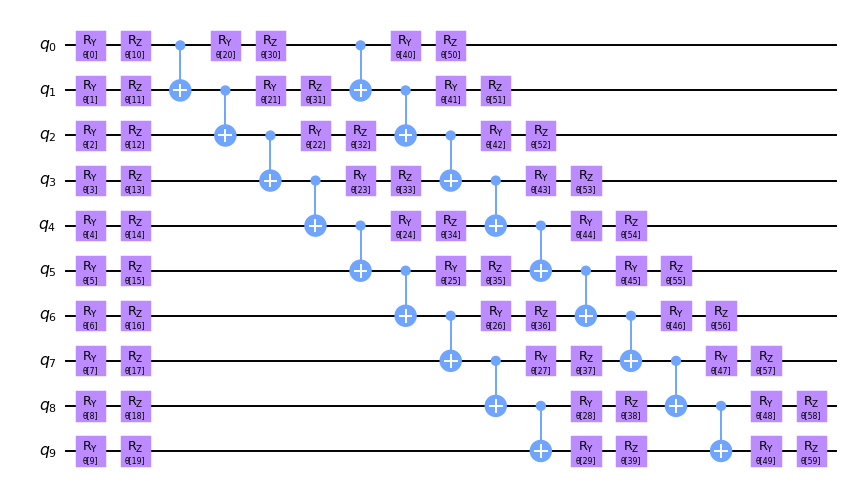

In [86]:
def get_two_locals(feature_dim, rotations, var_form_rep, ent):
    return TwoLocal(num_qubits=feature_dim, rotation_blocks=rotations, entanglement_blocks='cx', entanglement=ent, reps=var_form_rep)

ansatz_tl = get_two_locals(num_features, ['ry', 'rz'], 2, 'linear')
weights_params = ansatz_tl.parameters
ansatz_tl.decompose().draw('mpl', scale=0.7)

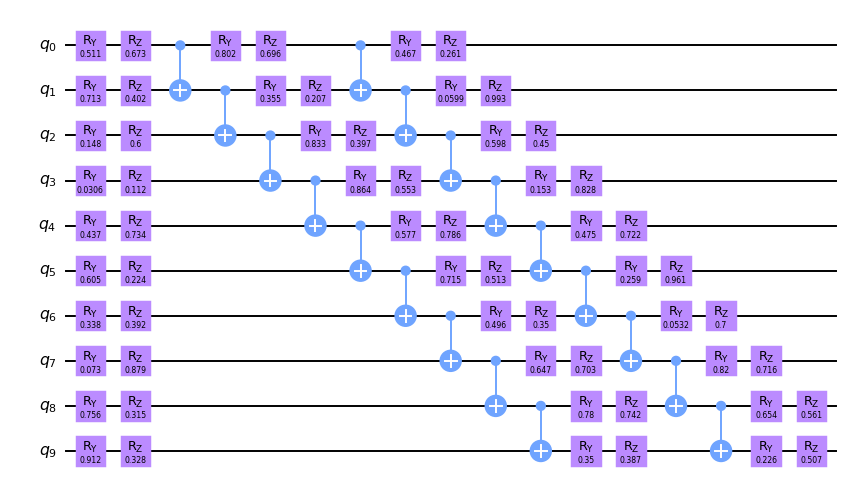

In [87]:
weights = np.random.random(len(ansatz_tl.parameters))
ansatz_tl.assign_parameters({k:v for (k,v) in zip(ansatz_tl.parameters, weights)}).decompose().draw('mpl', scale=0.7)


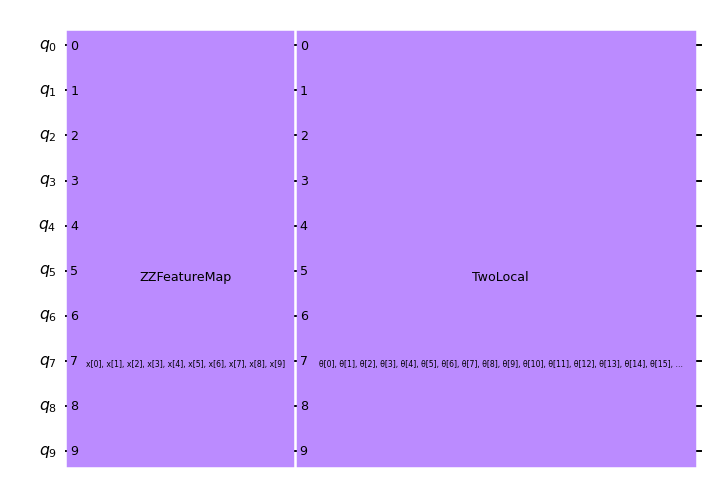

In [88]:
var_circuit = fmap_zz.compose(ansatz_tl)
var_circuit.draw('mpl', scale=0.7)

In [89]:
# for qiskit_ibm_runtime.Options, see https://docs.quantum.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.options.Options
options = {}
sampler = BackendSampler(backend=qasm_sim, options=options)
estimator = BackendEstimator(backend=qasm_sim, options=options)

In [90]:

def parity(x, num_classes):
    return f"{x:b}".count("1") % num_classes

def one_qubit_binary(x):
    return x % 2

In [91]:

def parity(x, num_classes):
    return f"{x:b}".count("1") % num_classes

def one_qubit_binary(x):
    return x % 2

In [92]:
var_circuit_with_meas = var_circuit.copy()
var_circuit_with_meas.measure_all()

In [93]:
paramShiftSampGrad = ParamShiftSamplerGradient(sampler=sampler)

sampler_qnn = SamplerQNN(sampler=sampler,
                         circuit=var_circuit_with_meas,
                         input_params=input_params,     # if your embedding strategy is not a parametrized circuit
                                                        # (e.g. amplitude encoding) you will have to do some extra work!
                         weight_params=weights_params,  # if you train your embedding as well, the trainable
                                                        # parameters of the embedding must be added
                         interpret=one_qubit_binary,
                         output_shape=2,
                         gradient=paramShiftSampGrad)

In [94]:
# The result of the neural network on a forward pass.
output = sampler_qnn.forward(X_train, weights)
print(f"Output shape for {len(X_train)} samples: {output.shape}")
print(f"Output of the forward pass for first sample: {output[0]}")

Output shape for 331 samples: (331, 2)
Output of the forward pass for first sample: [0.30761719 0.69238281]


In [95]:
# The result of the neural network on a backward pass
_, weights_grad = sampler_qnn.backward(X_train, weights)
print(f"Output shape for {len(X_train)} samples: {weights_grad.shape}")
print(f"Output of the backward pass for first sample: {weights_grad[0]}")

Output shape for 331 samples: (331, 2, 60)
Output of the backward pass for first sample: [[ 0.07861328 -0.00439453 -0.06298828  0.00585938  0.00439453 -0.00146484
   0.0078125  -0.00195312 -0.00683594  0.          0.15771484  0.19580078
  -0.09912109  0.01025391 -0.00244141  0.01025391  0.0078125  -0.01611328
   0.01367188 -0.01806641  0.05175781  0.05566406  0.01660156 -0.01367188
  -0.00195312 -0.01171875 -0.00146484  0.00634766  0.00341797  0.00390625
  -0.04736328 -0.109375   -0.00341797  0.01171875  0.01416016 -0.00830078
   0.00976562 -0.02001953 -0.00341797  0.00390625  0.07861328  0.
   0.00048828  0.00390625 -0.00585938  0.01464844 -0.01367188 -0.00830078
   0.01611328  0.01367188  0.01513672 -0.00927734  0.00634766 -0.01904297
  -0.00439453 -0.00292969 -0.00244141  0.00048828  0.01074219  0.00683594]
 [-0.07861328  0.00439453  0.06298828 -0.00585938 -0.00439453  0.00146484
  -0.0078125   0.00195312  0.00683594  0.         -0.15771484 -0.19580078
   0.09912109 -0.01025391  0.0

In [96]:
obs_parity = Pauli('Z' * num_features)
obs_one_qubit = Pauli('I' * (num_features - 1) + 'Z')
print(f"Parity observable: {obs_parity}")
print(f"First qubit observable: {obs_one_qubit}")

Parity observable: ZZZZZZZZZZ
First qubit observable: IIIIIIIIIZ


In [97]:
paramShiftEstGrad = ParamShiftEstimatorGradient(estimator=estimator)

estimator_qnn = EstimatorQNN(estimator=estimator,
                             circuit=var_circuit,
                             observables=obs_one_qubit,
                             input_params=input_params,     # if your embedding strategy is not a parametrized circuit
                                                            # (e.g. amplitude encoding) you will have to do some extra work!
                             weight_params=weights_params,  # if you train your embedding as well, the trainable
                                                            # parameters of the embedding must be added
                             gradient=paramShiftEstGrad)

In [98]:
# The result of the neural network on a forward pass.
output = estimator_qnn.forward(X_train, weights)
print(f"Output shape for {len(X_train)} samples: {output.shape}")
print(f"Output of the forward pass for first sample: {output[0]}")

Output shape for 331 samples: (331, 1)
Output of the forward pass for first sample: [-0.34960938]


In [99]:
# The result of the neural network on a backward pass
_, weights_grad = estimator_qnn.backward(X_train, weights)
print(f"Output shape for {len(X_train)} samples: {weights_grad.shape}")
print(f"Output of the backward pass for first sample: {weights_grad[0]}")

Output shape for 331 samples: (331, 1, 60)
Output of the backward pass for first sample: [[ 0.13671875 -0.01757812 -0.11816406  0.01660156 -0.01757812  0.03710938
   0.00683594  0.00976562 -0.01269531  0.03222656  0.27246094  0.3984375
  -0.19824219 -0.00683594  0.01757812  0.00585938 -0.0078125   0.02539062
  -0.01171875 -0.01171875  0.11230469  0.11914062 -0.00195312 -0.01855469
   0.00292969 -0.01855469  0.00488281 -0.0234375   0.04003906  0.01367188
  -0.08007812 -0.19140625  0.01757812  0.02929688  0.01171875  0.00878906
   0.00683594 -0.02539062  0.01171875 -0.0078125   0.1484375  -0.00683594
   0.00097656  0.          0.0078125  -0.02050781  0.00195312  0.02050781
   0.00292969 -0.02832031 -0.00878906  0.         -0.00390625 -0.04980469
   0.01660156  0.          0.01855469 -0.01171875 -0.02832031  0.03710938]]


In [100]:
def get_one_hot_encoding(y):
    unique_labels = np.unique(y, axis=0)
    y_one_hot = [(np.eye(len(unique_labels), dtype=int)[np.where(unique_labels == y_i)]).reshape(len(unique_labels)) for y_i in y]

    return np.array(y_one_hot)

y_train_1h = get_one_hot_encoding(y_train)
y_test_1h = get_one_hot_encoding(y_test)

print(f"Label {y_train[2]} converted to {y_train_1h[2]}")
print(f"Label {y_train[0]} converted to {y_train_1h[0]}")

Label 0 converted to [1 0]
Label 0 converted to [1 0]


In [101]:
def spsa_callback(nfev, params, fval, stepsize, accepted=None):
    """
    Can be used for SPSA and GradientDescent optimizers
    nfev: the number of function evals
    params: the current parameters
    fval: the current function value
    stepsize: size of the update step
    accepted: whether the step was accepted (not used for )
    """
    global spsa_loss_recorder

    if (nfev % 3) == 0:
        spsa_loss_recorder.append(fval)
        # print(f"SPSA Epoch {len(spsa_loss_recorder)}: {fval:.5f}")

In [102]:
max_itr = 100
spsa_opt = SPSA(maxiter=max_itr, callback=spsa_callback)
spsa_loss_recorder = []
initial_point = np.random.random((len(ansatz_tl.parameters),))
vqc = NeuralNetworkClassifier(neural_network=sampler_qnn,
                              loss=CrossEntropyLoss(),
                              one_hot=True,
                              optimizer=spsa_opt,
                              initial_point=initial_point)

vqc = vqc.fit(X_train, y_train_1h)

Text(0.5, 1.0, 'Training loss')

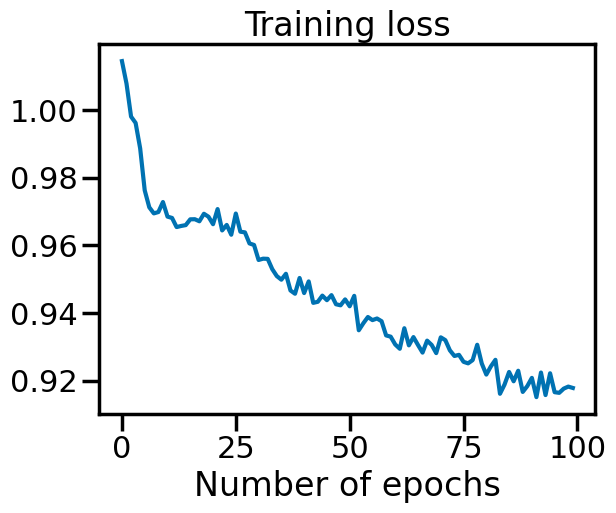

In [103]:
plt.plot(spsa_loss_recorder)
plt.xlabel("Number of epochs")
plt.title("Training loss")

In [104]:
score_train = vqc.score(X_train, y_train_1h)
score_test = vqc.score(X_test, y_test_1h)
print(f'Score on the train set {score_train}')
print(f'Score on the test set {score_test}')

Score on the train set 0.6676737160120846
Score on the test set 0.38738738738738737


In [105]:
y_train_pred = vqc.predict(X_train)
y_test_pred = vqc.predict(X_test)

In [106]:
train_pred_acc = np.all(y_train_pred == y_train_1h, axis=1)
test_pred_acc = np.all(y_test_pred == y_test_1h, axis=1)

Text(0.5, 1.0, 'ZZ Feature Map Performance')

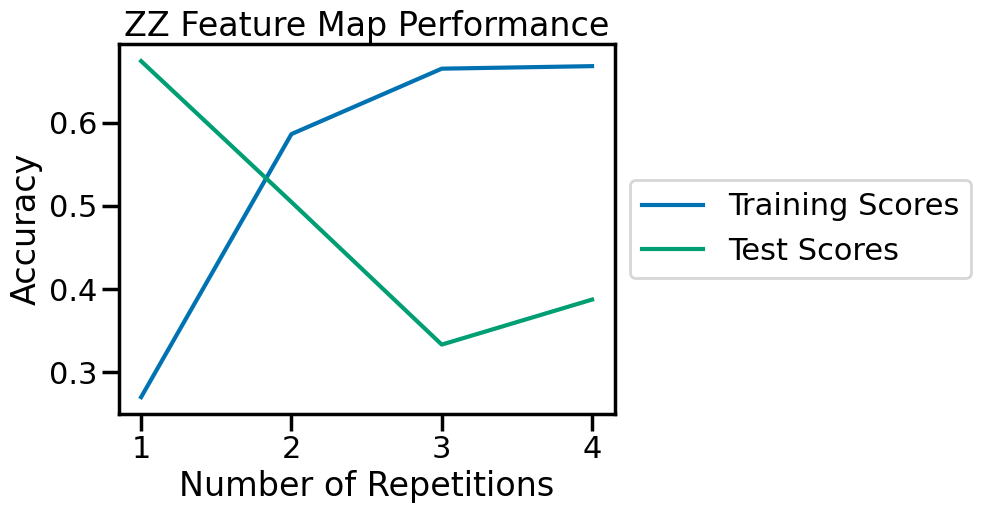

In [3]:
train_scores = [0.2702702702702703, 0.5861027190332326, 0.6646525679758308, 0.6676737160120846]
test_Scores = [0.6737160120845922,  0.5045045045045045, 0.3333333333333333, 0.38738738738738737]
number_of_reps = [1, 2, 3, 4]

plt.plot(number_of_reps, train_scores, label='Training Scores')
plt.plot(number_of_reps, test_Scores, label='Test Scores')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("Number of Repetitions")
plt.ylabel("Accuracy")
plt.title("ZZ Feature Map Performance")